In [1]:
# import the Libraries 
import numpy as np
import pandas as pd

#Maths stats
from numpy import mean, std
from math import sqrt

#data visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# data preprocessing
from category_encoders import TargetEncoder
from sklearn.preprocessing import RobustScaler

# scoring and cross-validation
from sklearn.model_selection import train_test_split, cross_val_score, ShuffleSplit, KFold, cross_validate
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV 
from sklearn import metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import RepeatedKFold

# ML algortihms regression
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from xgboost import XGBRegressor

# Module perso : helpers
import helpers # Le module du fichier python helper.py

In [2]:
pd.set_option("display.max_row",6000)
pd.set_option("display.max_column",100)
pd.set_option("display.precision", 3)
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{:.2f}'.format # to make legible

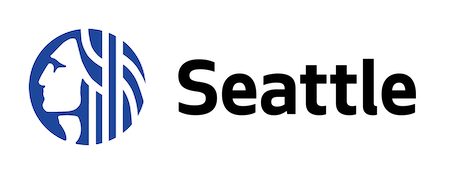

# <span class="bg-primary"> Modèle __Emissions de CO2__ Evaluation de l'intérêt de l'ESS<span>
# <span class="bg-danger">Introduction<span>
    
__Buts de la mission:__
    
La ville de Seattle souhaite atteindre son objectif de ville neutre en émissions de carbone en 2050. Des relevés minutieux ont été effectués en __2015 et 2016__. Afin de poursuivre son ambitieux programme tout en en limitant le coût, la ville a besoin de prédictions. Trois objectifs principaux ont été fixés :
   
- _Prédire, grâce à une modélisation, la consommation totale d'énergie de bâtiments_<span> 
    
- <span class="bg-danger">Prédire, grâce à une modélisation, leurs __émissions de GES__<span>
    
- <span class="bg-danger">Evaluer la pertinence d'un indicateur d'efficacité énergétique appelé __Energy Star Score__<span>

# <span class="bg-danger">Sommaire<span>

# <span class="bg-danger">A. Modèle émissions de CO2<span>
___    
__<span class="bg-info">1.<span>__ __Chargement et préparation des données__
    
__<span class="bg-warning">1_1.<span>__ Séparation des variables indépendantes et de la cible
___
__<span class="bg-warning">1_2.<span>__ Séparation du jeu de données train/test
___
__<span class="bg-warning">1_3.<span>__ Encodage/Standardisation/Sauvegarde
___
__<span class="bg-info">2.<span>__ __Apprentissage automatique__ : tester différents algorithmes de ML
___
__<span class="bg-warning">2_1.<span>__ Modèles linéaires/Modèles non linéaires
___
__<span class="bg-warning">2_3.<span>__ Bilan et sélection de l'algorithme le plus performant
___   
__<span class="bg-info">3.<span>__ __Optimisations des hyperparamètres XGBOOST (GridSearchCV)__
___
__<span class="bg-warning"><span>__ Sauvegarde du modèle optimisé avec joblib    

__<span class="bg-info">4.<span>__ __Prédictions__
    
__<span class="bg-info">5.<span>__ __Complément : Sélection itérative des variables (RFECV)__

# <span class="bg-danger">B. Evaluation de l'intérêt de l'ESS<span>
___    
__<span class="bg-info">1.<span>__ __Comparaison des modèles AVEC ou SANS ESS__
    
__<span class="bg-info">2.<span>__ __Conclusion__
    
__<span class="bg-info">3.<span>__ __Complément : Sélection itérative des variables (RFECV) AVEC ESS__

# <span class="bg-danger">A. Modèle émissions de CO2<span>

# <span class="bg-success">1. Chargement et préparation des données<span>

In [3]:
# import the dataset
data_etude = pd.read_csv('data_etude_nettoyage.csv')
data_etude.drop('Unnamed: 0', axis=1, inplace=True)

In [4]:
#sauvegarde séparée du energy star score
energy_star_score = data_etude['ENERGYSTARScore']
data_etude.drop('ENERGYSTARScore', axis=1, inplace=True)

## <span class="bg-info">1.1 Séparation des variables indépendantes et de la cible<span>

In [5]:
data_etude_encode = data_etude.copy()

In [6]:
#variables dépendantes
y = data_etude_encode.copy()[{'SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions',
                   'Log10_SiteEnergyUseWN(kBtu)', 'Log10_TotalGHGEmissions'}]
#variables indépendantes
X = data_etude_encode.copy().drop(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions',
                        'Log10_SiteEnergyUseWN(kBtu)', 'Log10_TotalGHGEmissions' ], axis=1)

## <span class="bg-info">1.2 Séparation du jeu de données train/test<span>

In [7]:
# split the dataset into test set and train set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y['Log10_TotalGHGEmissions'], test_size = 0.2, random_state = 23)

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2708, 20), (2708,), (677, 20), (677,))

## <span class="bg-info">1.3.1 Encodage<span>

In [9]:
X_train_categorical_columns =X_train[['BuildingType', 'Neighborhood', 'Outlier', 'PrimaryPropertyType','LargestPropertyUseType', 'SecondLargestPropertyUseType','ThirdLargestPropertyUseType']].columns 
X_test_categorical_columns =X_test[['BuildingType', 'Neighborhood', 'Outlier', 'PrimaryPropertyType','LargestPropertyUseType', 'SecondLargestPropertyUseType','ThirdLargestPropertyUseType']].columns

In [10]:
#encode
from category_encoders import TargetEncoder
encoder = TargetEncoder()
X_train[X_train_categorical_columns] = encoder.fit_transform(X_train[X_train_categorical_columns], y_train)
X_test[X_train_categorical_columns] = encoder.transform(X_test[X_test_categorical_columns])

C:\Users\Troussard Family\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


## <span class="bg-info">1.3.2 Standardisation<span>

In [11]:
X_train_numerical_columns =X_train[['CouncilDistrictCode', 'Latitude','Longitude','NumberofBuildings','NumberofFloors','YearBuilt' ,'PropertyGFABuilding(s)', 'RatioLargestUseGFA', 'RatioSecondUseGFA','RatioThirdUseGFA']].columns 
X_test_numerical_columns =X_test[['CouncilDistrictCode', 'Latitude','Longitude','NumberofBuildings','NumberofFloors','YearBuilt' ,'PropertyGFABuilding(s)', 'RatioLargestUseGFA', 'RatioSecondUseGFA','RatioThirdUseGFA']].columns

In [12]:
#centrer et réduire les données d'apprentissage
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

rs = RobustScaler()
X_train.loc[:, X_train_numerical_columns] = rs.fit_transform(X_train[X_train_numerical_columns])
X_test.loc[:, X_test_numerical_columns] = rs.transform(X_test[X_test_numerical_columns])

## <span class="bg-info">1.3.3 Sauvegarde encodage/Standardisation<span>

In [13]:
#Utilisation de JobLib pour sérialiser et enregistrer l'encodage
from joblib import dump, load
# save encoding to disk
dump(encoder , 'encodage_emission_saved.joblib', compress=1)
dump(rs , 'scaler_emission_saved.joblib', compress=1)

['scaler_emission_saved.joblib']

# <span class="bg-success">2. Apprentissage automatique : tester différents algorithmes de ML<span>

## <span class="bg-info">Modèles linéaires / Non linéaires<span>

## <span class="bg-info">Recherche accélérée du meilleur modèle pour les émissions de GES<span>

__Grâce à 3 fonctions du module personnel "helpers"__, nous allons :
- __Créer une liste de régresseurs__ de base.
- __Fournir un résumé des résultats__ de la validation croisée des modèles.
- __Fournir un résumé des performances__ des modèles de référence pour une mesure (R2, MSE ou MAE)afin de __sélectionner le meilleur modèle__

Ceci nous permettra d'accélérer notre exploration.

In [14]:
models = helpers.create_baseline_regressors()
summary = helpers.assess_models(X_train, y_train, models)
summary

,dum,lin,svr,dtr,rfr,etr,xgb
fit_time_mean,0.00,0.00,0.14,0.02,0.93,0.65,0.09
fit_time_std,0.00,0.00,0.01,0.00,0.01,0.00,0.00
score_time_mean,0.00,0.00,0.02,0.00,0.01,0.02,0.00
score_time_std,0.00,0.00,0.00,0.00,0.00,0.00,0.00
test_neg_mean_squared_error_mean,-0.43,-0.19,-0.11,-0.17,-0.09,-0.09,-0.10
test_neg_mean_squared_error_std,0.03,0.10,0.01,0.02,0.01,0.00,0.01
test_r2_mean,-0.00,0.55,0.75,0.59,0.78,0.78,0.76
test_r2_std,0.00,0.19,0.02,0.05,0.02,0.02,0.02


In [15]:
helpers.extract_metric(summary, 'r2');

In [16]:
helpers.extract_metric(summary, 'neg_mean_squared_error');

## <span class="bg-info">Bilan et sélection de l'algorithme le plus performant<span> 

__Conclusions :__

Comme nous l'avions prévu, les mêmes algorithmes que pour la consommation d'énergie sont performants :
- Random forest
- Extra trees
- XGBOOST

Nous avons déjà cherché à optimiser les hyperparamètres de ces 3 algorithmes pour la consommation d'énergie. Essayons d'utiliser le modèle sauvegardé pour __XGBOOST__.

#  <span class="bg-success">3. Optimisations des hyperparamètres XGBOOST (GridSearchCV)<span> 

Comme nous l'avions remarqué dans la première partie, les variables cibles 'SiteEnergyUseWN(kBtu)' et 'TotalGHGEmissions'sont __fortement corrélées__. Nous pouvons donc essayer d'utiliser le modèle utilisé pour faire la prédiction de la consommation d'énergie. (estimateur : XGBOOST, modèle : xgb3).

<AxesSubplot:>

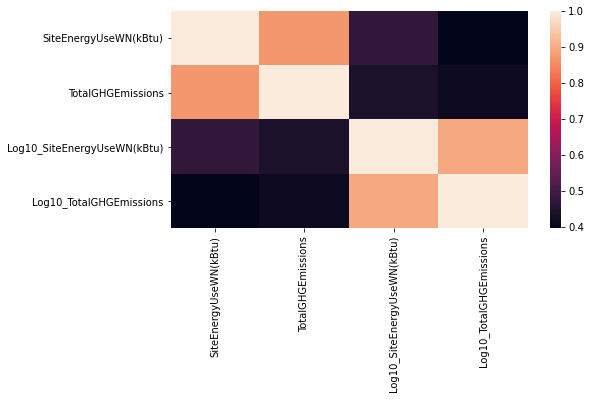

In [17]:
col_to_keep = ['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions',
               'Log10_SiteEnergyUseWN(kBtu)', 'Log10_TotalGHGEmissions']
plt.figure(figsize = (8,4))
sns.heatmap(data_etude[col_to_keep].corr())

## <span class="bg-info">Modèle XGBOOST à optimiser<span>

__Réutiliser le modèle xgb3__

In [18]:
from joblib import dump, load
xgb3_loaded, et2_loaded, rf2_loaded = load('regression_models_saved.joblib')
xgb3_loaded;

In [19]:
#Modèle de départ, à optimiser, nous imprimons les métriques pour comparaison

# Define the model
xgb_em = XGBRegressor(learning_rate = 0.05,
                   n_estimators=250,
                   max_depth=4,
                   min_child_weight=1,
                   gamma=0,
                   subsample=0.7,
                   colsample_bytree=0.8,
                   reg_alpha = 1e-09, 
                   reg_lambda = 1,
                   nthread=4,
                   seed=27)

# Fit the model
xgb_em.fit(X_train, y_train)

#Predicting using test set
y_pred = xgb_em.predict(X_test)

# Printing the metrics
mse_xgb_em=metrics.mean_squared_error(y_test, y_pred)
r2_xgb_em=metrics.r2_score(y_test, y_pred)
print('R2 square:', r2_xgb_em)
print('MSE: ', mse_xgb_em)

R2 square: 0.7959544989384926
MSE:  0.08536547192248935


## <span class="bg-info">Optimiser les hyperparamètres du modèle avec __GridSearchCV__<span> 

In [20]:
# grid search CV à partir de xgb3
model = XGBRegressor()

param_grid = {
        'n_estimators' : [200, 250, 300, 400, 500],
        'learning_rate': [0.01, 0.04, 0.05, 0.06, 0.1],
                                      }
# Instantiate the grid search model
gsearch = GridSearchCV(estimator = model, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 0)
gsearch.fit(X_train, y_train)
gsearch.best_params_, gsearch.best_score_

({'learning_rate': 0.05, 'n_estimators': 200}, 0.7856578376415241)

In [21]:
#Modèle optimisé xgb_best
# Define the model
xgb_best = XGBRegressor(n_estimators = 200,
                   learning_rate = 0.04)

# Fit the model
xgb_best.fit(X_train, y_train)

#Predicting using train set
y_train_pred = xgb_best.predict(X_train)

#Predicting using test set
y_test_pred = xgb_best.predict(X_test)

# Printing the metrics
mse_xgb_best = mean_squared_error(y_test, y_test_pred)
r2_xgb_best = r2_score(y_test, y_test_pred)
print('R2 square:', r2_xgb_best)
print('MSE: ', mse_xgb_best)

R2 square: 0.787629021180806
MSE:  0.08884855944006646


In [22]:
scoring = ['r2', 'neg_mean_squared_error']
scores = cross_validate(xgb_best, X_train, y_train, cv=5,
                        scoring=scoring, return_train_score=True)
# report performance
pd.DataFrame(scores).T;

## <span class="bg-info">Sauvegarde du modèle optimisé avec joblib<span>

In [23]:
#Utilisation de JobLib pour sérialiser et enregistrer les modèles
from joblib import dump, load
# save the model to disk
dump(xgb_best , 'emission_regression_model_saved.joblib', compress=1)

['emission_regression_model_saved.joblib']

# <span class="bg-success">4. Prédictions<span>  

## <span class="bg-info">Evaluation graphique des prédictions<span>  

Text(0, 0.5, 'y_test_pred')

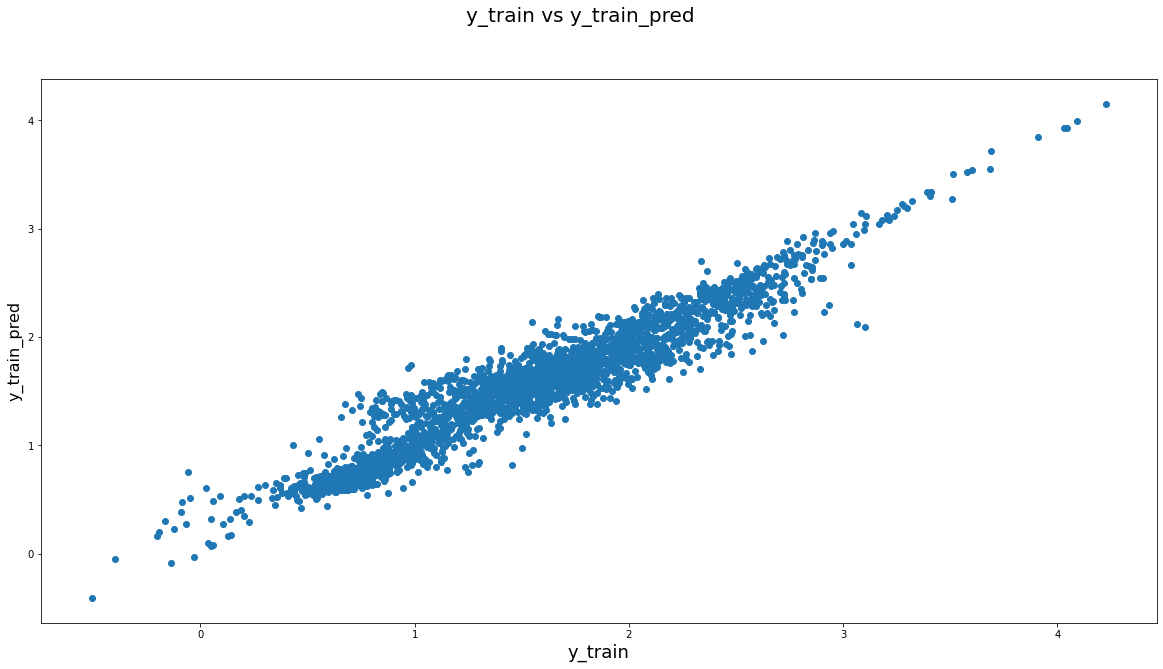

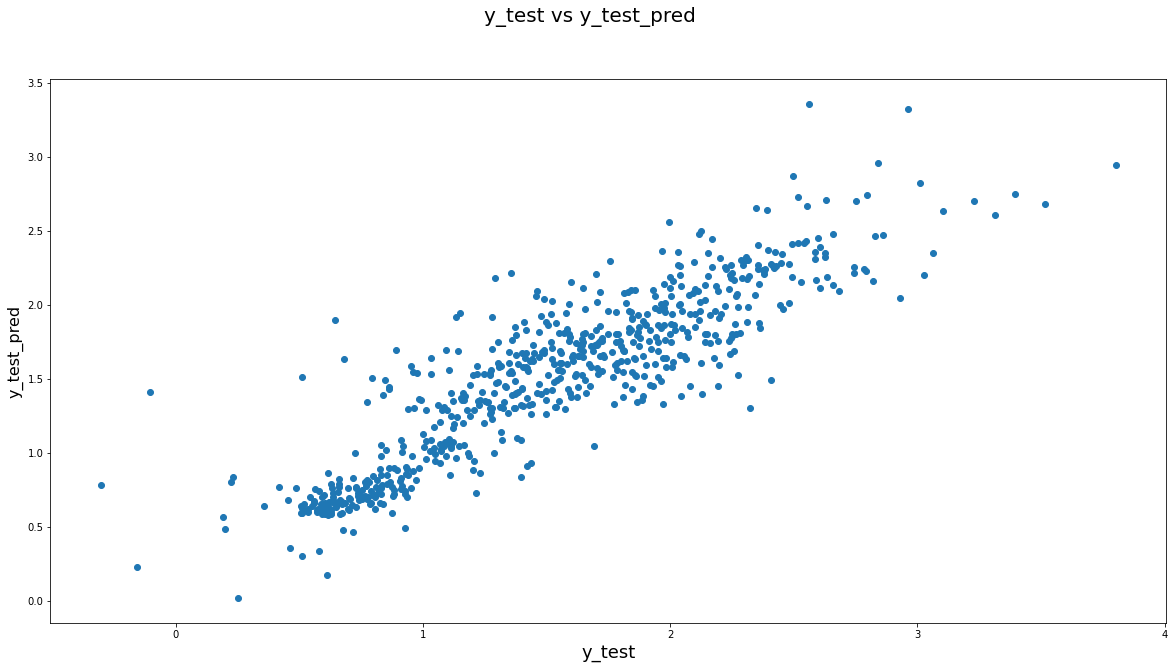

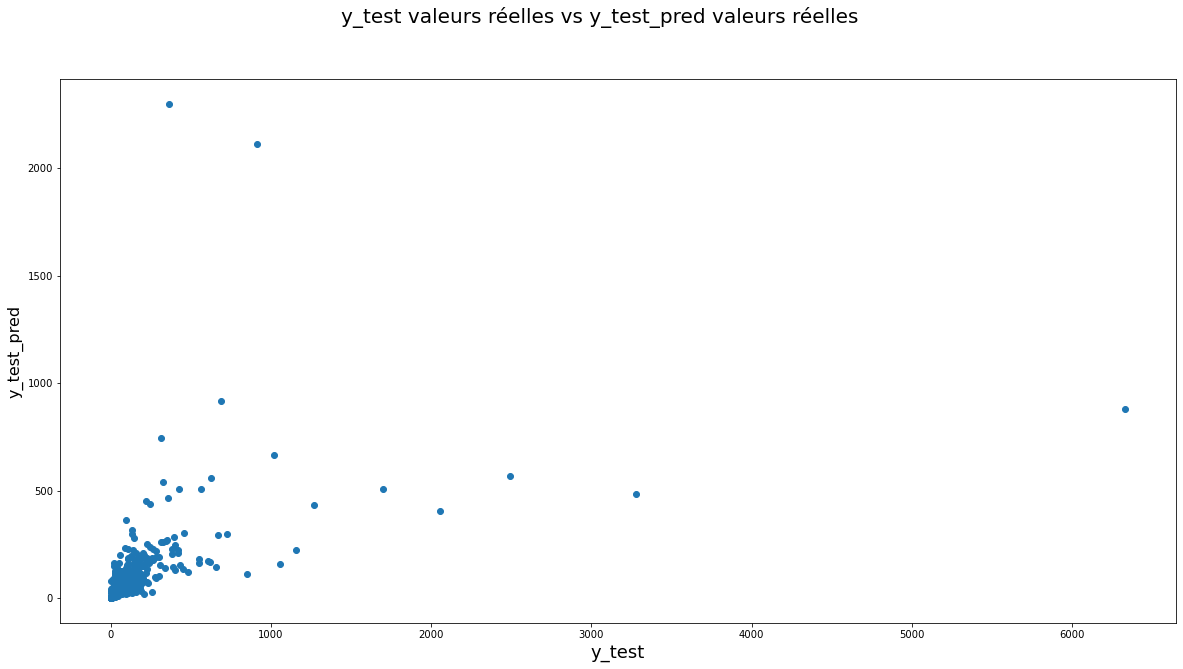

In [24]:
# Plotting y_test and y_test_pred to understand the spread.
fig = plt.figure(figsize=(20,10))
plt.scatter(y_train, y_train_pred)
fig.suptitle('y_train vs y_train_pred', fontsize=20)        # Plot heading 
plt.xlabel('y_train', fontsize=18)                          # X-label
plt.ylabel('y_train_pred', fontsize=16)                     # Y-label

fig = plt.figure(figsize=(20,10))
plt.scatter(y_test,y_test_pred)
fig.suptitle('y_test vs y_test_pred', fontsize=20)         # Plot heading 
plt.xlabel('y_test', fontsize=18)                          # X-label
plt.ylabel('y_test_pred', fontsize=16)                     # Y-label


fig = plt.figure(figsize=(20,10))
plt.scatter(10**y_test, 10**y_test_pred)
fig.suptitle('y_test valeurs réelles vs y_test_pred valeurs réelles', fontsize=20)         # Plot heading 
plt.xlabel('y_test valeurs réelles', fontsize=18)                          # X-label
plt.ylabel('y_test_pred valeurs réelles', fontsize=16)                     # Y-label

In [25]:
X_test_essai = X_test
y_test_essai = y_test
prediction = xgb_best.predict(X_test_essai)

In [26]:
predictions = pd.DataFrame([y_test_essai, 
                            pd.Series(prediction, index = y_test_essai.index),
                           10**(y_test_essai),
                           10**(pd.Series(prediction, index = y_test_essai.index))]).T
predictions.columns = ['y_log10', 'y_predict_log10', 'y','y_predict']

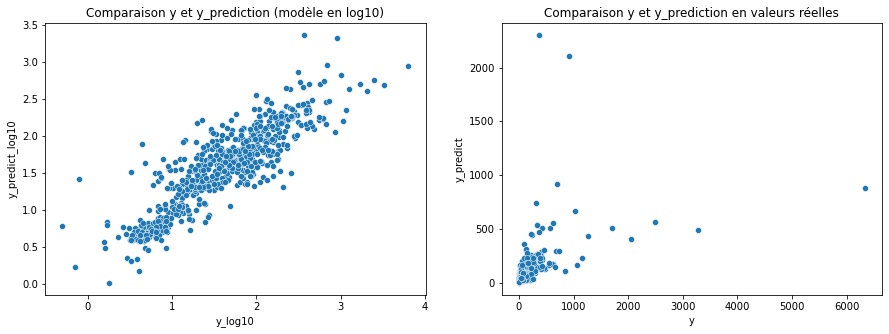

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5), sharey=False)
sns.scatterplot(x = predictions['y_log10'], y = predictions['y_predict_log10'], ax = ax1)
sns.scatterplot(x = predictions['y'], y = predictions['y_predict'], ax=ax2)

ax1.title.set_text('Comparaison y et y_prediction (modèle en log10)')
ax2.title.set_text('Comparaison y et y_prediction en valeurs réelles')

# <span class="bg-success">5. Sélection itératives de variables<span>  

## <span class="bg-info">RFECV (Sans ENERGY STAR Score)<span>  

In [28]:
from sklearn.feature_selection import RFECV
regressor = XGBRegressor(random_state=101)
selector = RFECV(estimator=regressor, step=1, scoring='neg_mean_squared_error', cv = 5)
selector.fit(X_train, y_train)

RFECV(cv=5,
      estimator=XGBRegressor(base_score=None, booster=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, gamma=None, gpu_id=None,
                             importance_type='gain',
                             interaction_constraints=None, learning_rate=None,
                             max_delta_step=None, max_depth=None,
                             min_child_weight=None, missing=nan,
                             monotone_constraints=None, n_estimators=100,
                             n_jobs=None, num_parallel_tree=None,
                             random_state=101, reg_alpha=None, reg_lambda=None,
                             scale_pos_weight=None, subsample=None,
                             tree_method=None, validate_parameters=None,
                             verbosity=None),
      scoring='neg_mean_squared_error')

In [29]:
print('Le nombre optimal de variables est {}'.format(selector.n_features_))
features = [f for f,s in zip(X_train.columns, selector.support_) if s]
print('Les variables sélectionnées sont:')
print ('{}'.format(features))

Le nombre optimal de variables est 15
Les variables sélectionnées sont:
['BuildingType', 'Latitude', 'Longitude', 'Outlier', 'NumberofFloors', 'YearBuilt', 'PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'PropertyGFABuilding(s)', 'RatioLargestUseGFA', 'RatioSecondUseGFA', 'RatioThirdUseGFA', 'SteamUse', 'NaturalGasUse']


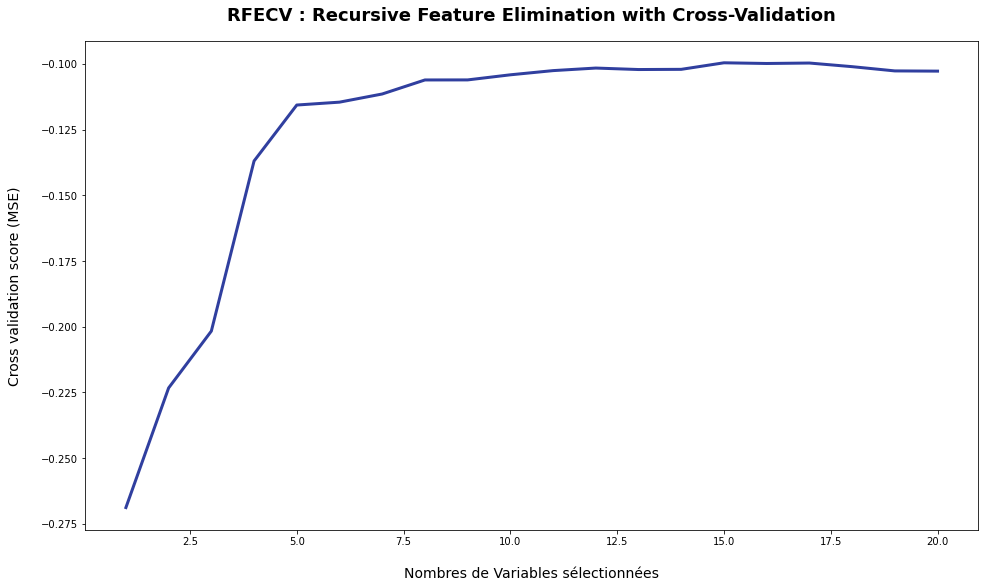

In [30]:
plt.figure(figsize=(16, 9))
plt.title('RFECV : Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Nombres de Variables sélectionnées', fontsize=14, labelpad=20)
plt.ylabel("Cross validation score (MSE)", fontsize=14, labelpad=20)
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [31]:
print(np.where(selector.support_ == False)[0])

X_train.drop(X_train.columns[np.where(selector.support_ == False)[0]], axis=1, inplace = True)

[ 1  2  6 12 18]


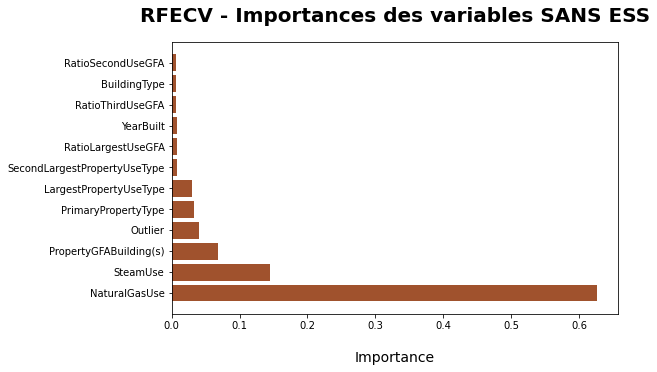

In [32]:
dset = pd.DataFrame()
dset['variables'] = X_train.columns
dset['importance'] = selector.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False).head(12)


plt.figure(figsize=(8, 5))
plt.barh(y=dset['variables'], width=dset['importance'], color='sienna')
plt.title('RFECV - Importances des variables SANS ESS', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()

## <span class="bg-info">Nouvel essai XGBOOST après sélection (12 variables retenues sur 20) <span> 

In [33]:
X_train_s = X_train[features]
X_test_s = X_test[features]

In [34]:
# Define the model
xgb_em_rfe = XGBRegressor(n_estimators = 200,
                   learning_rate = 0.04)

# Fit the model
xgb_em_rfe.fit(X_train_s, y_train)

#Predicting using test set
y_pred = xgb_em_rfe.predict(X_test_s)

# Metrics
mse_xgb_em_rfe=metrics.mean_squared_error(y_test, y_pred)
r2_xgb_em_rfe=metrics.r2_score(y_test, y_pred)

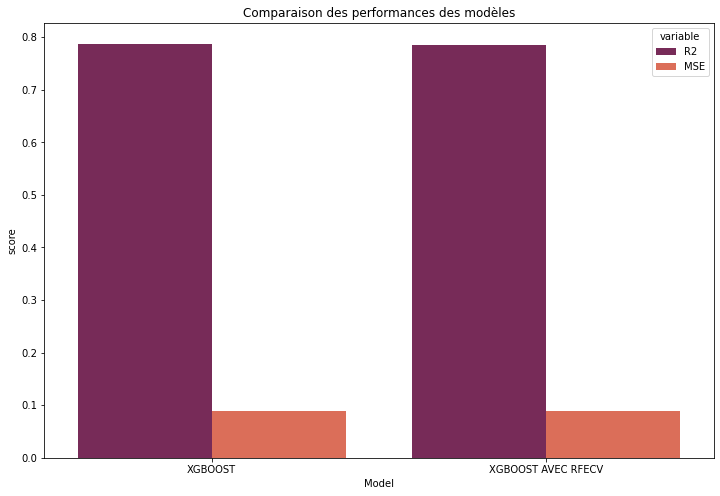

In [35]:
#Comparaison des modèles sans ou avec sélection de variables
comparaison_score = pd.DataFrame({
    'Model': ['XGBOOST', 'XGBOOST AVEC RFECV'],
    'R2': [ r2_xgb_best, r2_xgb_em_rfe],
    'MSE': [ mse_xgb_best, mse_xgb_em_rfe]})
comparaison_score_melt = pd.melt(comparaison_score, id_vars = ['Model'], value_name = 'score', value_vars=['R2', 'MSE'])
#Visualisation
plt.figure(figsize=(12,8))
sns.barplot(x = comparaison_score_melt['Model'],
            y = comparaison_score_melt['score'], hue = comparaison_score_melt['variable'], palette = "rocket" )
plt.title('Comparaison des performances des modèles')
plt.show()

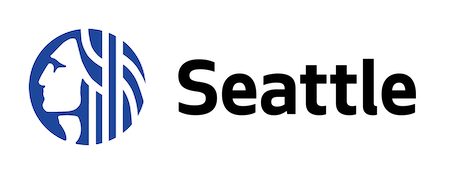

# <span class="bg-danger">B. Intérêt de l'ENERGY STAR SCORE pour la prédiction d'émissions<span>

In [36]:
data_etude = pd.read_csv('data_etude_nettoyage.csv')
data_etude.drop('Unnamed: 0', axis=1, inplace=True)

__Suppression des valeurs manquantes de la variables ENERGYSTARScore__

In [37]:
data_etude.dropna(axis =0, inplace=True)

## <span class="bg-info">Séparation variables indépendantes/cible ; train/test set<span>

In [38]:
data_energy_encode = data_etude.copy()
#variables dépendantes
y_en = data_energy_encode.copy()[{'SiteEnergyUseWN(kBtu)','TotalGHGEmissions', 
                   'Log10_SiteEnergyUseWN(kBtu)', 'Log10_TotalGHGEmissions'}]
#variables indépendantes
X_en = data_energy_encode.copy().drop(['SiteEnergyUseWN(kBtu)', 'TotalGHGEmissions', 
                        'Log10_SiteEnergyUseWN(kBtu)', 'Log10_TotalGHGEmissions'], axis=1)

In [39]:
# split the dataset into test set and train set
from sklearn.model_selection import train_test_split
X_en_train, X_en_test, y_en_train, y_en_test = train_test_split(X_en, y_en['Log10_TotalGHGEmissions'], test_size = 0.2, random_state = 23)

## <span class="bg-info">Encodage/Standardisation<span>

In [40]:
X_en_train_categorical_columns =X_en_train[['BuildingType', 'Neighborhood', 'Outlier', 'PrimaryPropertyType','LargestPropertyUseType', 'SecondLargestPropertyUseType','ThirdLargestPropertyUseType']].columns 
X_en_test_categorical_columns =X_en_test[['BuildingType', 'Neighborhood', 'Outlier', 'PrimaryPropertyType','LargestPropertyUseType', 'SecondLargestPropertyUseType','ThirdLargestPropertyUseType']].columns

In [41]:
#encode
encoder = TargetEncoder()
X_en_train[X_en_train_categorical_columns] = encoder.fit_transform(X_en_train[X_en_train_categorical_columns], y_en_train)
X_en_test[X_en_train_categorical_columns] = encoder.transform(X_en_test[X_en_test_categorical_columns])

C:\Users\Troussard Family\anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [42]:
X_en_train_numerical_columns =X_en_train[['ENERGYSTARScore','CouncilDistrictCode', 'Latitude','Longitude','NumberofBuildings','NumberofFloors','YearBuilt' ,'PropertyGFABuilding(s)', 'RatioLargestUseGFA', 'RatioSecondUseGFA','RatioThirdUseGFA']].columns 
X_en_test_numerical_columns =X_en_test[['ENERGYSTARScore','CouncilDistrictCode', 'Latitude','Longitude','NumberofBuildings','NumberofFloors','YearBuilt' ,'PropertyGFABuilding(s)', 'RatioLargestUseGFA', 'RatioSecondUseGFA','RatioThirdUseGFA']].columns

In [43]:
#centrer et réduire les données d'apprentissage
rs = RobustScaler()
X_en_train.loc[:, X_en_train_numerical_columns] = rs.fit_transform(X_en_train[X_en_train_numerical_columns])
X_en_test.loc[:, X_en_test_numerical_columns] = rs.transform(X_en_test[X_en_test_numerical_columns])

# <span class="bg-success">1. Comparaison d'un modèle AVEC ou SANS la variable ESS<span>

## <span class="bg-info">Entraînons le modèle avec la variable ENERGY STAR Score<span>

In [44]:
# Define the model
xgb_ess = XGBRegressor(n_estimators = 200,
                   learning_rate = 0.04,
                   nthread=4,
                   seed=27)
# Fit the model
xgb_ess.fit(X_en_train, y_en_train)

#Predicting using test set
y_en_pred = xgb_ess.predict(X_en_test)

# Metrics
mse_xgb_ess = metrics.mean_squared_error(y_en_test, y_en_pred)
r2_xgb_ess = metrics.r2_score(y_en_test, y_en_pred)

In [45]:
scoring = ['r2', 'neg_mean_squared_error']
scores = cross_validate(xgb_ess, X_en_train, y_en_train, cv=5,
                        scoring=scoring, return_train_score=True)
# report performance
pd.DataFrame(scores).T;

# <span class="bg-success">2. Conclusion<span>

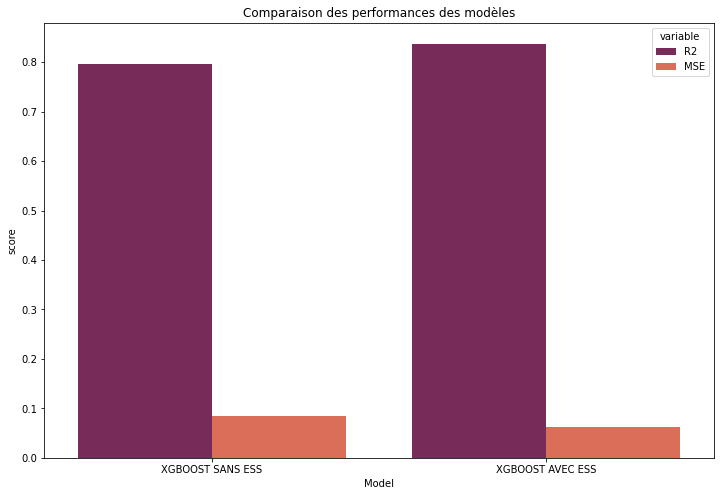

In [46]:
#Comparaison du modèle émission AVEC ou SANS la variable EnergyStarScore
comparaison_score = pd.DataFrame({
    'Model': ['XGBOOST SANS ESS', 'XGBOOST AVEC ESS'],
    'R2': [ r2_xgb_em, r2_xgb_ess],
    'MSE': [ mse_xgb_em, mse_xgb_ess]})
comparaison_score_melt = pd.melt(comparaison_score, id_vars = ['Model'], value_name = 'score', value_vars=['R2', 'MSE'])
#Visualisation
plt.figure(figsize=(12,8))
sns.barplot(x = comparaison_score_melt['Model'],
            y = comparaison_score_melt['score'], hue = comparaison_score_melt['variable'], palette = "rocket" )
plt.title('Comparaison des performances des modèles')
plt.show()

In [47]:
comparaison_score

,Model,R2,MSE
0,XGBOOST SANS ESS,0.80,0.09
1,XGBOOST AVEC ESS,0.84,0.06


L'ajout de la variable ESS au modèle __améliore légèrement la performance.__
Mais la variable est __fastidieuse__ à obtenir. 

__Arbitrage à prévoir__ pour décider de son intérêt selon 2 axes de considérations : performance versus coût.

# <span class="bg-success">3. Complément : sélection itérative de variables<span>

## <span class="bg-info">RFECV avec la variable ENERGY STAR Score<span>

In [48]:
from sklearn.feature_selection import RFECV
regressor = XGBRegressor(random_state=101)
selector = RFECV(estimator=regressor, step=1, scoring='neg_mean_squared_error', cv = 5)
selector.fit(X_en_train, y_en_train)

RFECV(cv=5,
      estimator=XGBRegressor(base_score=None, booster=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, gamma=None, gpu_id=None,
                             importance_type='gain',
                             interaction_constraints=None, learning_rate=None,
                             max_delta_step=None, max_depth=None,
                             min_child_weight=None, missing=nan,
                             monotone_constraints=None, n_estimators=100,
                             n_jobs=None, num_parallel_tree=None,
                             random_state=101, reg_alpha=None, reg_lambda=None,
                             scale_pos_weight=None, subsample=None,
                             tree_method=None, validate_parameters=None,
                             verbosity=None),
      scoring='neg_mean_squared_error')

In [49]:
print('Le nombre optimal de variables est {}'.format(selector.n_features_))
features = [f for f,s in zip(X_en_train.columns, selector.support_) if s]
print('Les variables sélectionnées sont:')
print ('{}'.format(features))

Le nombre optimal de variables est 15
Les variables sélectionnées sont:
['BuildingType', 'Outlier', 'NumberofFloors', 'YearBuilt', 'PrimaryPropertyType', 'LargestPropertyUseType', 'SecondLargestPropertyUseType', 'ThirdLargestPropertyUseType', 'PropertyGFABuilding(s)', 'RatioLargestUseGFA', 'RatioSecondUseGFA', 'RatioThirdUseGFA', 'SteamUse', 'NaturalGasUse', 'ENERGYSTARScore']


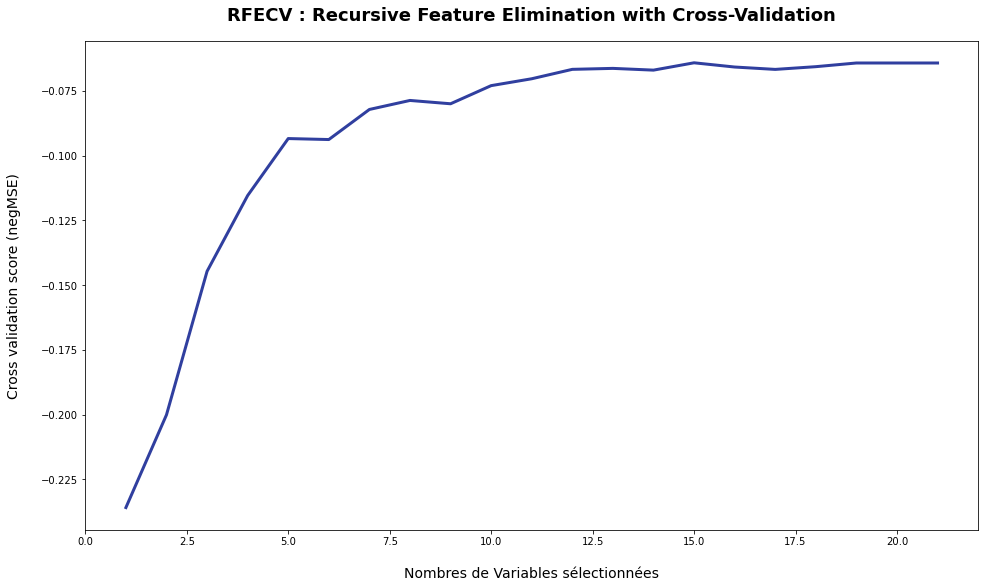

In [50]:
plt.figure(figsize=(16, 9))
plt.title('RFECV : Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Nombres de Variables sélectionnées', fontsize=14, labelpad=20)
plt.ylabel("Cross validation score (negMSE)", fontsize=14, labelpad=20)
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

In [51]:
print(np.where(selector.support_ == False)[0])

X_en_train.drop(X_en_train.columns[np.where(selector.support_ == False)[0]], axis=1, inplace = True)

[ 1  2  3  4  6 18]


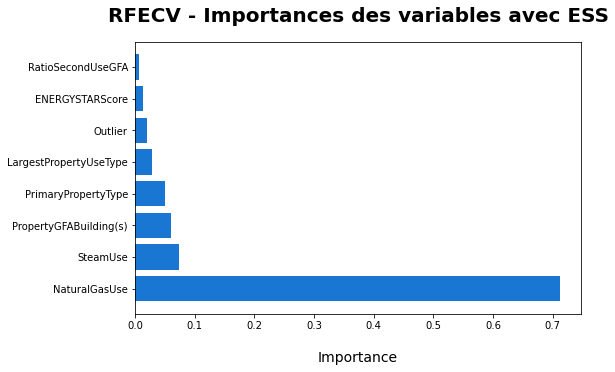

In [52]:
dset = pd.DataFrame()
dset['variables'] = X_en_train.columns
dset['importance'] = selector.estimator_.feature_importances_

dset = dset.sort_values(by='importance', ascending=False).head(8)


plt.figure(figsize=(8, 5))
plt.barh(y=dset['variables'], width=dset['importance'], color='#1976D2')
plt.title('RFECV - Importances des variables avec ESS', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('Importance', fontsize=14, labelpad=20)
plt.show()